# NLP Assignment 2 (40% of grade): Vector Space Semantics for Similarity between Eastenders Characters

In this assignment, you will be creating a vector representation of a document containing lines spoken by a character in the Eastenders script data (i.e. from the file `training.csv`), then improving that representation such that each character vector is maximially distinguished from the other character documents. This distinction is measured by how well a simple information retrieval classification method can select documents from validation and test data as belonging to the correct class of document (i.e. deciding which character spoke the lines by measuring the similarity of those character document vectors to those built in training).

As the lines are not evenly distributed in terms of frequency, this coursework stipulates you can only use a maximum of the first **400 lines** of each character in the training data `training.csv` to create the training documents, and a maximum of the first **40 lines** in the test data (from `test.csv`). This makes it more challenging, as number of lines spoken by a character can't be used directly or otherwise as a feature.

A simple vector representation for each character document is done for you to start with in this code, as is the pipeline of similarity-based information retrieval based evaluation. You need to improve the character vector representations by pre-processing, feature extraction and transformation techniques, as per Questions 1-6 below, which you need to complete as instructed.

**Refer to the material in units 8-9 for conceptual background.**

# Q1. Improve pre-processing (20 marks)
Using the pre-processing techniques you have learned in the module, improve the `pre_process` function above, which currently just tokenizes text based on white space.

When developing, use the 90% train and 10% validation data split from the training file, using the first 360 lines from the training split and first 40 lines from the validation split, as per above. To check the improvements by using the different techniques, use the `compute_IR_evaluation_scores` function as above. The **mean rank** is the main metric you need to focus on improving throughout this assignment, where the target/best possible performance is **1** (i.e. all test/validation data character documents are closest to their corresponding training data character documents) and the worst is **16**. Initially the code in this template achieves a mean rank of **5.12**  and accuracy of **0.3125** on the test set and a mean rank of **4.5** and accuracy of - you should be looking to improve those, particularly getting the mean rank as close to 1 as possible.

# Q2. Improve linguistic feature extraction (20 marks)
Use the feature extraction techniques you have learned to improve the `to_feature_vector_dictionary` function above. Examples of extra features could include extracting n-grams of different lengths and including POS-tags. You could also use sentiment analysis or another text classifier's result when applied to the features for each character document. You could even use a gender classifier trained on the same data using the GENDER column **(but DO NOT USE the GENDER column directly in the features for the final vector)**.

You could use feature selection/reduction with techniques like minimum/maximum document frequency and/or feature selection like k-best selection using different statistical tests https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html. Again, develop on 90% training and 10% validation split and note the effect/improvement in mean rank with the techniques you use.

# Q3. Analyse the similarity results (10 marks)
From your system so far run on the 90%/10% training/validation split, identify the heldout character vectors ranked closest to each character's training vector which are not the character themselves, and those furthest away, as displayed using the `plot_heat_map_similarity` function. In your report, try to ascribe reasons why this is the case, particularly for those where there isn't a successful highest match between the target character in the training set and that character's vector in the heldout set yet. Observations you could make include how their language use is similar, resulting in similar word or ngram features.

In [1]:
!pip install nltk

In [2]:
pip install num2words

Note: you may need to restart the kernel to use updated packages.


In [3]:
import string
import re
import numpy as np
from numpy.linalg import norm
import pandas as pd
from collections import Counter, OrderedDict

import seaborn as sns
import matplotlib.pyplot as plt

import nltk

from sklearn.feature_extraction import DictVectorizer

%matplotlib inline
pd.options.display.max_colwidth=500

# additional imports for preprocesssing
from string import punctuation

# to lemmatise words
from nltk.stem import WordNetLemmatizer 

# for stemming
from nltk.stem import PorterStemmer

# used to iterate on true and false for pre-processing
from itertools import product
import pandas as pd

from num2words import num2words

In [4]:
# Load in training data and display in pandas dataframe
train_path='training.csv'
all_train_data = pd.read_csv(train_path,  delimiter="\t", skip_blank_lines = True)
test_path ='test.csv'
test_data = pd.read_csv(test_path,  delimiter="\t", skip_blank_lines = True)

In [5]:
# Split into training and test data for heldout validation with random samples of 9:1 train/heldout split
from random import shuffle, seed

seed(0) # set a seed for reproducibility so same split is used each time

epsiode_scene_column = all_train_data.Episode.astype(str) + "-" + all_train_data.Scene.astype(str)
all_train_data['episode_scene'] = epsiode_scene_column

# 1350-1 1350-2 --> sorted
episode_scenes = sorted(list(set([x for x in epsiode_scene_column.values]))) # need to sort to ensure same initial order

# after sorting, shuffled
shuffle(episode_scenes)

print(f'total number of of episode scenes -> {len(episode_scenes)}')
episode_split = int(0.9*len(episode_scenes))

# 90% of the data to the training set, 0 to 90% border
training_ep_scenes = episode_scenes[:episode_split]
# 10% of the data to the test set, from 90% to 100% border
test_ep_scenes = episode_scenes[episode_split:]
print(f'Total number of training episode scenes -> {len(training_ep_scenes)}\nTotal number of episode test episode scenes -> {len(test_ep_scenes)}')

def train_or_heldout_eps(val):
    if val in training_ep_scenes:
        return "training"
    return "heldout"

# adding a new column to identify if data is in training set or heldout (test set)
all_train_data['train_heldout'] = all_train_data['episode_scene'].apply(train_or_heldout_eps)

total number of of episode scenes -> 1394
Total number of training episode scenes -> 1254
Total number of episode test episode scenes -> 140


In [6]:
print('Raw Data: ',np.shape(all_train_data))
train_data = all_train_data[all_train_data['train_heldout']=='training']
val_data = all_train_data[all_train_data['train_heldout']=='heldout']
print('Train set: ',np.shape(train_data))
print('Validation set: ',np.shape(val_data))

Raw Data:  (15319, 8)
Train set:  (13638, 8)
Validation set:  (1681, 8)


In [7]:
# Inspect
print('---- Raw Data ----')
all_train_data

---- Raw Data ----


,Episode,Scene,Scene_info,Character_name,Line,Gender,episode_scene,train_heldout
0,1350,1,DESERTED CAR PARK EXT NIGHT,SHIRLEY,"Look at ya, not a mark on ya. And you think you're an unlucky man.",FEMALE,1350-1,training
1,1350,1,DESERTED CAR PARK EXT NIGHT,OTHER,Shirl...,MALE,1350-1,training
2,1350,2,R&R INT NIGHT,JACK,Oi. Where have you been? Huh? What were the texts about?,MALE,1350-2,training
3,1350,2,R&R INT NIGHT,RONNIE,Nothing. Nothing. I'll be with you in two minutes yeah?,FEMALE,1350-2,training
4,1350,2,R&R INT NIGHT,JACK,"Well I've got mates here I wanted to have a chat with them, instead I've been serving behind the bar.",MALE,1350-2,training
...,...,...,...,...,...,...,...,...
15314,1399,55,SQUARE EXT DAY LIGHT,OTHER,"Dad? Okay ... alright, just one drink alright. But that's all. It doesn't mean anything. It's just a drink.",MALE,1399-55,training
15315,1399,55,SQUARE EXT DAY LIGHT,MAX,Thanks Bradley. Thanks mate... It means the world to me...,MALE,1399-55,training
15316,1399,55,SQUARE EXT DAY LIGHT,OTHER,You alright...,MALE,1399-55,training
15317,1399,55,SQUARE EXT DAY LIGHT,MAX,"Yeah, yeah, yeah. I'm fine.",MALE,1399-55,training


In [8]:
print('---- Train Data ----')
train_data

---- Train Data ----


,Episode,Scene,Scene_info,Character_name,Line,Gender,episode_scene,train_heldout
0,1350,1,DESERTED CAR PARK EXT NIGHT,SHIRLEY,"Look at ya, not a mark on ya. And you think you're an unlucky man.",FEMALE,1350-1,training
1,1350,1,DESERTED CAR PARK EXT NIGHT,OTHER,Shirl...,MALE,1350-1,training
2,1350,2,R&R INT NIGHT,JACK,Oi. Where have you been? Huh? What were the texts about?,MALE,1350-2,training
3,1350,2,R&R INT NIGHT,RONNIE,Nothing. Nothing. I'll be with you in two minutes yeah?,FEMALE,1350-2,training
4,1350,2,R&R INT NIGHT,JACK,"Well I've got mates here I wanted to have a chat with them, instead I've been serving behind the bar.",MALE,1350-2,training
...,...,...,...,...,...,...,...,...
15314,1399,55,SQUARE EXT DAY LIGHT,OTHER,"Dad? Okay ... alright, just one drink alright. But that's all. It doesn't mean anything. It's just a drink.",MALE,1399-55,training
15315,1399,55,SQUARE EXT DAY LIGHT,MAX,Thanks Bradley. Thanks mate... It means the world to me...,MALE,1399-55,training
15316,1399,55,SQUARE EXT DAY LIGHT,OTHER,You alright...,MALE,1399-55,training
15317,1399,55,SQUARE EXT DAY LIGHT,MAX,"Yeah, yeah, yeah. I'm fine.",MALE,1399-55,training


In [9]:
print('---- Val Data ----')
val_data

---- Val Data ----


,Episode,Scene,Scene_info,Character_name,Line,Gender,episode_scene,train_heldout
56,1350,18,BRANNINGS' HOUSE INT NIGHT,TANYA,Who's that?,FEMALE,1350-18,heldout
57,1350,18,BRANNINGS' HOUSE INT NIGHT,MAX,Tanya! Tanya it's me. I wanna give Oscar a New Year kiss. Tan?,MALE,1350-18,heldout
58,1350,18,BRANNINGS' HOUSE INT NIGHT,SEAN,Right. I'll have a word.,MALE,1350-18,heldout
59,1350,18,BRANNINGS' HOUSE INT NIGHT,TANYA,"No no no leave it, leave it. He ain't got a key. He'll go away. Do you want some crisps?",FEMALE,1350-18,heldout
60,1350,18,BRANNINGS' HOUSE INT NIGHT,MAX,"Who, who you got in there, Tan? Tan, I've got a right to know who my kids are being exposed to. I bet you ain't got anyone have ya? You're just sitting there with a bottle of wine all on your Jack, Tan?",MALE,1350-18,heldout
...,...,...,...,...,...,...,...,...
15268,1399,29,[NAME] & [NAME]'S HOUSE INT NIGHT,STACEY,"I asked him to leave you. I asked him again and again. I begged him. And if he had. I'd have been with him. I'd have been with him now. So it might suit you to think that it was all Max but it wasn't, not really, not in the end.",FEMALE,1399-29,heldout
15269,1399,29,[NAME] & [NAME]'S HOUSE INT NIGHT,TANYA,Why you telling me all this eh?,FEMALE,1399-29,heldout
15270,1399,29,[NAME] & [NAME]'S HOUSE INT NIGHT,STACEY,"Because I don't want you using Sean to punish him, I don't want you wrecking your family cause of me. I just, I just want it all over.",FEMALE,1399-29,heldout
15271,1399,29,[NAME] & [NAME]'S HOUSE INT NIGHT,TANYA,It is over. It's all over. Will you please just go home now and leave me alone.,FEMALE,1399-29,heldout


In [10]:
if False:
    # A simpler alternative to the above, but where a high split means some characters
    # may be left out
    print('Raw Data: ',np.shape(all_train_data))
    idx = int(0.9 * np.shape(all_train_data)[0])
    train_data = all_train_data[:idx]
    val_data = all_train_data[idx:]
    print('Train set: ',np.shape(train_data))
    print('Validation set: ',np.shape(val_data))

In [11]:
# Create one document per character
def create_character_document_from_dataframe(df, max_line_count):
    """Returns a dict with the name of the character as key,
    their lines joined together as a single string, with end of line _EOL_
    markers between them.
    
    ::max_line_count:: the maximum number of lines to be added per character
    """
    character_docs = {}
    character_line_count = {}
    for line, name, gender in zip(df.Line, df.Character_name, df.Gender):
        if not name in character_docs.keys():
            character_docs[name] = ""
            character_line_count[name] = 0
        if character_line_count[name]==max_line_count:
            continue
        character_docs[name] += str(line)   + " _EOL_ "  # adding an end-of-line token
        character_line_count[name]+=1
    print("lines per character", character_line_count)
    return character_docs

In [12]:
# print out the number of words each character has in the training set
# only use the first 360 lines of each character
# there is 16 characters --> each character, only 360 lines recorded in training --> in total 5760 lines from training data (13638 lines)
print('--- Training set dataframe document ---')
train_character_docs = create_character_document_from_dataframe(train_data, max_line_count=360)
print('Num. Characters: ',len(train_character_docs.keys()),"\n")
total_words = 0
ordered_train_docs = {}
for name in train_character_docs.keys():
    ordered_train_docs[name] = len(train_character_docs[name].split())
    total_words += len(train_character_docs[name].split())

ordered_train_docs = dict(sorted(ordered_train_docs.items(), key=lambda item: item[1]))
for name,word_len in ordered_train_docs.items():
    print(name, 'Number of Words: ',word_len)
print("total words", total_words)
print()

# get the validation data- only 40 lines used for each character
print('--- Validation set dataframe document ---')
val_character_docs = create_character_document_from_dataframe(val_data, max_line_count=40)
print('Num. Characters: ',len(val_character_docs.keys()),"\n")
total_words = 0
ordered_val_docs = {}
for name in val_character_docs.keys():
    ordered_val_docs[name] = len(val_character_docs[name].split())
    total_words += len(val_character_docs[name].split())
ordered_val_docs = dict(sorted(ordered_val_docs.items(), key=lambda item: item[1]))
for name,word_len in ordered_val_docs.items():
    print(name, 'Number of Words: ',word_len)
print("total words", total_words)

--- Training set dataframe document ---
lines per character {'SHIRLEY': 360, 'OTHER': 360, 'JACK': 360, 'RONNIE': 360, 'TANYA': 360, 'SEAN': 360, 'ROXY': 360, 'HEATHER': 360, 'MAX': 360, 'IAN': 360, 'JANE': 360, 'STACEY': 360, 'PHIL': 360, 'MINTY': 360, 'CHRISTIAN': 342, 'CLARE': 352}
Num. Characters:  16 

OTHER Number of Words:  3244
RONNIE Number of Words:  3442
PHIL Number of Words:  3635
SEAN Number of Words:  3637
JANE Number of Words:  3648
CHRISTIAN Number of Words:  3738
TANYA Number of Words:  3786
ROXY Number of Words:  3838
SHIRLEY Number of Words:  3848
STACEY Number of Words:  3913
MINTY Number of Words:  4005
HEATHER Number of Words:  4098
IAN Number of Words:  4332
CLARE Number of Words:  4344
MAX Number of Words:  4363
JACK Number of Words:  4435
total words 62306

--- Validation set dataframe document ---
lines per character {'TANYA': 40, 'MAX': 40, 'SEAN': 35, 'SHIRLEY': 40, 'OTHER': 40, 'STACEY': 40, 'RONNIE': 40, 'JACK': 40, 'PHIL': 40, 'IAN': 40, 'JANE': 40, 'ROXY

### Question 1: For pre-processing, techniques that will be experimented on:
 * separating punctuation - including punctuation still in the token
 * convert text numbers to digits
 * punctuation removal - including punctuations in between words such as ain't --> aint
 * replace $100 or £100 to money
 * replace numbers to #
 * lowercasing
 * stemming/lemmatization
 * stopword removal

In [13]:
# convert number word texts to digits
# taken from https://github.com/ShailChoksi/text2digits
def text_to_digits(textnum, numwords={}):
    if not numwords:
        units = [
        "zero", "one", "two", "three", "four", "five", "six", "seven", "eight",
        "nine", "ten", "eleven", "twelve", "thirteen", "fourteen", "fifteen",
        "sixteen", "seventeen", "eighteen", "nineteen",
        ]

        tens = ["", "", "twenty", "thirty", "forty", "fifty", "sixty", "seventy", "eighty", "ninety"]

        scales = ["hundred", "thousand", "million", "billion", "trillion"]

        numwords["and"] = (1, 0)
        for idx, word in enumerate(units):  numwords[word] = (1, idx)
        for idx, word in enumerate(tens):       numwords[word] = (1, idx * 10)
        for idx, word in enumerate(scales): numwords[word] = (10 ** (idx * 3 or 2), 0)

    ordinal_words = {'first':1, 'second':2, 'third':3, 'fifth':5, 'eighth':8, 'ninth':9, 'twelfth':12}
    ordinal_endings = [('ieth', 'y'), ('th', '')]

    textnum = textnum.replace('-', ' ')

    current = result = 0
    curstring = ""
    onnumber = False
    for word in textnum.split():
        if word in ordinal_words:
            scale, increment = (1, ordinal_words[word])
            current = current * scale + increment
            if scale > 100:
                result += current
                current = 0
            onnumber = True
        else:
            for ending, replacement in ordinal_endings:
                if word.endswith(ending):
                    word = "%s%s" % (word[:-len(ending)], replacement)

            if word not in numwords:
                if onnumber:
                    curstring += repr(result + current) + " "
                curstring += word + " "
                result = current = 0
                onnumber = False
            else:
                scale, increment = numwords[word]

                current = current * scale + increment
                if scale > 100:
                    result += current
                    current = 0
                onnumber = True

    if onnumber:
        curstring += repr(result + current)

    return curstring

In [14]:
# contain preprocessing investigations with True or False
pre_process_invest = {
'is_separate_punctuation_front_back_sentence': False, 
'is_to_num_text_to_digits': False, # do this before convert money amount to money and removal of punctuation
'is_remove_punctuations': False, 
'is_replace_money_amount_to_money': False, # use this before removing or separating punctuation
'is_replace_digits_to_num_hash': False,
'is_to_lower_case': False,
'is_to_lemmatize': False,
'is_to_remove_stop_words': False,
'is_to_num_to_words': False
}

In [15]:
def pre_process(character_text):
    """Pre-process all the concatenated lines of a character, 
    using tokenization, spelling normalization and other techniques.
    
    Initially just a tokenization on white space. Improve this for Q1.
    
    ::character_text:: a string with all of one character's lines
    """
    
    if(pre_process_invest['is_to_num_text_to_digits']):
        character_text = text_to_digits(character_text)
        character_text = re.sub(r'(\d+ )(dollars|dollar)',r'$\1',character_text) # convert 24 dollars to $24
        character_text = re.sub(r'(\d+ )(pounds|pound)',r'£\1',character_text) # convert 24 dollars to £24
        character_text = re.sub(r'(\d+ )(cents|cent)',r'$0.\1',character_text) # convert 24 cents to $0.24
        character_text = re.sub(r'(\d+ )(pence|penny)',r'£0.\1',character_text) # convert 24 pence to £0.24
    
     
    if(pre_process_invest['is_to_num_to_words']):
        character_text = re.sub(r'(\$)(\d+.\d+)',r'\2 dollars', character_text) # convert $0.2 to 0.2 dollars
        character_text = re.sub(r'(£)(\d+.\d+)',r'\2 pounds', character_text) # convert £0.2 to 0.2 pounds
        character_text = re.sub(r'(\d+)(.)(\d+)',r'\1 point \3', character_text) # convert 0.2 to 0 point 2
        character_text = re.sub(r'(\$)(\d+)',r'\2 dollars', character_text) # convert $50 to 50 dollars
        character_text = re.sub(r'(£)(\d+)',r'\2 pounds', character_text) # convert £50 to 50 pounds
        character_text = ''.join(map(str,[re.sub('(\d+)', lambda m: num2words(m.group()), text) for text in [character_text]]))

    
    if(pre_process_invest['is_replace_money_amount_to_money']):
        # convert '£100' to 'money'
        character_text = re.sub(r"(£|\$)\d+(?:\.\d+)?", "money", character_text)
    
    if(pre_process_invest['is_separate_punctuation_front_back_sentence']):
        # separate punctuation at the front and back of the sentence
        # note: this is still a text, not a token yet!
        character_text = re.sub(r"(\w)([.,;:!?'\"”\)])", r"\1 \2", character_text) 
        character_text = re.sub(r"([.,;:!?'\"“\(\)])(\w)", r"\1 \2", character_text)
    
    if(pre_process_invest['is_remove_punctuations'] == True):
        character_text = character_text.translate(str.maketrans('','',punctuation))
    
    if(pre_process_invest['is_replace_digits_to_num_hash']):
        # convert e.g. 21 to #
        character_text = re.sub('\d+', '#',character_text)
        
    if(pre_process_invest['is_to_lower_case']):
        # convert to lower case
        character_text = character_text.lower()
        
    ##### split white spaces, convert text to array of words
    tokens = character_text.split()   
    
    # change word to base root
    if(pre_process_invest['is_to_lemmatize']):
        tokens = [WordNetLemmatizer().lemmatize(token) for token in tokens]
    
    # removal of stop words such as a, the, is, are
    if(pre_process_invest['is_to_remove_stop_words']):
        stopword_list = nltk.corpus.stopwords.words('english')
        tokens = [token for token in tokens if token not in stopword_list] 
        
    return tokens

In [16]:
def to_feature_vector_dictionary(character_doc, extra_features):
    """Converts a list of pre-processed tokens and extra features
    to a Dictionary as a function of the tokens.
    
    Initially just a simple count. Improve this for Q2.
    
    ::character_doc:: a list of pre-processed tokens
    ::extra_features:: any extra features for the character to be added to feature vector dict
    """
    counts = Counter(character_doc)  # for now a simple count
    counts = dict(counts)
    # add the extra features, for now just adding one count for each extra feature
    countcount = 0
    for feature in extra_features:
        counts[feature] += 1        
    return counts  

In [17]:
corpusVectorizer = DictVectorizer()   # corpusVectorizor which will just produce sparse vectors from feature dicts
# Any matrix transformers (e.g. tf-idf transformers) should be initialized here


def create_document_matrix_from_corpus(corpus, fitting=False):
    """Method which fits different vectorizers
    on data and returns a matrix.
    
    Currently just does simple conversion to matrix by vectorizing the dictionary. Improve this for Q3.
    
    ::corpus:: a list of (class_label, document) pairs.
    ::fitting:: a boolean indicating whether to fit/train the vectorizers (should be true on training data)
    """
    # uses the global variable of the corpus Vectorizer to improve things
    if fitting:
        corpusVectorizer.fit([to_feature_vector_dictionary(doc, []) for name, doc in corpus])
    doc_feature_matrix = corpusVectorizer.transform([to_feature_vector_dictionary(doc, []) for name, doc in corpus])
    
    #training_feature_matrix[0].toarray()
    return doc_feature_matrix

In [18]:
def compute_cosine_similarity(v1, v2):
    """Takes a pair of vectors v1 and v2 (1-d arrays e.g. [0, 0.5, 0.5])
    returns the cosine similarity between the vectors
    """
    
    # compute cosine similarity manually
    manual_cosine_similarity = np.dot(v1, v2)  /(norm(v1) * norm(v2))
    
    return manual_cosine_similarity

In [19]:
def compute_IR_evaluation_scores(train_feature_matrix, test_feature_matrix, train_labels, test_labels):
    """
    Computes an information retrieval based on training data feature matrix and test data feature matrix
    returns 4-tuple:
    ## similarity in  test and training, mean rank --> ranking each character or document with regards to training and testing data
    ## weighing and classification
    ## argmax = the one most similar
    ## rank, how far down the vector is at the correct character determined
    ## the lower the mean rank the better
    ## if the rank is 16 for all for each character --> the worst
    ######
    ## classification ranking ---> then get the total and get the mean = mean ranking
    ::mean_rank:: mean of the ranking of the target document in terms of similarity to the query/test document
    1 is the best possible score.
    
    ## feature vector size, 
    ::mean_cosine_similarity:: mean cosine similarity score for the target document vs. the test document of the same class
    ::accuracy:: proportion of test documents correctly classified
    ::df:: a data frame with all the similarity measures of the test documents vs. train documents
    
    params:
    ::train_feature_matrix:: a numpy matrix N x M shape where N = number of characters M = number of features
    ::test_feature_matrix::  a numpy matrix N x M shape where N = number of characters M = number of features
    ::train_labels:: a list of character names for the training data in order consistent with train_feature_matrix
    ::test_labels:: a list of character names for the test data in order consistent with test_feature_matrix
    """
    rankings = []
    all_cosine_similarities = []
    pairwise_cosine_similarity = []
    pairs = []
    correct = 0
    for i, target in enumerate(test_labels):
        # compare the left out character against the mean
        idx = i 
        fm_1 = test_feature_matrix.toarray()[idx]
        all_sims = {}
        # print("target:", target)
        for j, other in enumerate(train_labels):
            fm_2 = train_feature_matrix.toarray()[j]
            manual_cosine_similarity = compute_cosine_similarity(fm_1, fm_2)
            pairs.append((target, other))
            pairwise_cosine_similarity.append(manual_cosine_similarity)
            if other == target:
                all_cosine_similarities.append(manual_cosine_similarity)
            all_sims[other] = manual_cosine_similarity

            # print(target, other, manual_cosine_similarity)
        sorted_similarities = sorted(all_sims.items(),key=lambda x:x[1],reverse=True)
        # print(sorted_similarities)
        ranking = {key[0]: rank for rank, key in enumerate(sorted_similarities, 1)}
        # print("Ranking for target", ranking[target])
        if ranking[target] == 1:
            correct += 1
        rankings.append(ranking[target])
        # print("*****")
    mean_rank = np.mean(rankings)
    mean_cosine_similarity = np.mean(all_cosine_similarities)
    accuracy = correct/len(test_labels)
    ###print("mean rank", np.mean(rankings))
    ###print("mean cosine similarity", mean_cosine_similarity)
    ###print(correct, "correct out of", len(test_labels), "/ accuracy:", accuracy )
    
    # get a dafaframe showing all the similarity scores of training vs test docs
    df = pd.DataFrame({'doc1': [x[0] for x in pairs], 'doc2': [x[1] for x in pairs],
                       'similarity': pairwise_cosine_similarity})

    # display characters which are most similar and least similar
    df.loc[[df.similarity.values.argmax(), df.similarity.values.argmin()]]
    ###print(df)
    return (mean_rank, mean_cosine_similarity, accuracy, df)

In [20]:
def plot_heat_map_similarity(df):
    """Takes a dataframe with header 'doc1, doc2, similarity'
    Plots a heatmap based on the similarity scores.
    """
    test_labels =  sorted(list(set(df.sort_values(['doc1'])['doc1'])))
    # add padding 1.0 values to either side
    cm = [[1.0,] * (len(test_labels)+2)]
    for target in test_labels:
        new_row = [1.0]
        for x in df.sort_values(['doc1', 'doc2'])[df['doc1']==target]['similarity']:
            new_row.append(x)
        new_row.append(1.0)
        cm.append(new_row)
    cm.append([1.0,] * (len(test_labels)+2))
    #print(cm)
    labels = [""] + test_labels + [""]
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Similarity matrix between documents as vectors')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):

            text = ax.text(j, i, round(cm[i][j],3),
                           ha="center", va="center", color="w")

    plt.xlabel('Training Vector Doc')
    plt.ylabel('Test Vector Doc')
    #fig.tight_layout()
    plt.show()

In [21]:
dic_invest_length = len(pre_process_invest)

true_false = [False, True]


true_false_combi = product(true_false, repeat=dic_invest_length)

df_pre_processing = pd.DataFrame(data = list(true_false_combi), columns=pre_process_invest.keys())
df_pre_processing['mean_rank'] = ''
df_pre_processing['mean_cosine_simliarity'] = ''
df_pre_processing['acc'] = ''
df_pre_processing

,is_separate_punctuation_front_back_sentence,is_to_num_text_to_digits,is_remove_punctuations,is_replace_money_amount_to_money,is_replace_digits_to_num_hash,is_to_lower_case,is_to_lemmatize,is_to_remove_stop_words,is_to_num_to_words,mean_rank,mean_cosine_simliarity,acc
0,False,False,False,False,False,False,False,False,False,,,
1,False,False,False,False,False,False,False,False,True,,,
2,False,False,False,False,False,False,False,True,False,,,
3,False,False,False,False,False,False,False,True,True,,,
4,False,False,False,False,False,False,True,False,False,,,
...,...,...,...,...,...,...,...,...,...,...,...,...
507,True,True,True,True,True,True,False,True,True,,,
508,True,True,True,True,True,True,True,False,False,,,
509,True,True,True,True,True,True,True,False,True,,,
510,True,True,True,True,True,True,True,True,False,,,


In [22]:
key_count = len(pre_process_invest.keys())
df_val_container = {}
num_rows = len(df_pre_processing)
print(f'To process: {num_rows} rows')
counter = 0
for row in range(len(df_pre_processing)):
    counter+=1
    # first place the True False values in the dictionary
    for key_col in range(key_count):  
        pre_process_invest[df_pre_processing.columns[key_col]] = df_pre_processing.iloc[row].values[key_col]
    # once True False values placed, preprocess and get values
    # create list of pairs of (character name, pre-processed character) 
    training_corpus = [(name, pre_process(doc)) for name, doc in sorted(train_character_docs.items())]
    train_labels = [name for name, doc in training_corpus]
    training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True)
    
    # create list of pairs of (character name, pre-processed character) 
    val_corpus = [(name, pre_process(doc)) for name, doc in sorted(val_character_docs.items())]
    val_labels = [name for name, doc in val_corpus]
    # Just transform the val_feature_matrix, don't fit
    val_feature_matrix = create_document_matrix_from_corpus(val_corpus, fitting=False)

    mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, val_feature_matrix, train_labels, val_labels)
    df_pre_processing.iloc[row, df_pre_processing.columns.get_loc('mean_rank')] = mean_rank
    df_pre_processing.iloc[row, df_pre_processing.columns.get_loc('mean_cosine_simliarity')] = mean_cosine_simliarity
    df_pre_processing.iloc[row, df_pre_processing.columns.get_loc('acc')] = acc
    df_val_container[row] = df
    if(counter % 100 == 0):
        print(f'Processed rows: {counter}/{num_rows}')
display(df_pre_processing)

To process: 512 rows
Processed rows: 100/512
Processed rows: 200/512
Processed rows: 300/512
Processed rows: 400/512
Processed rows: 500/512


,is_separate_punctuation_front_back_sentence,is_to_num_text_to_digits,is_remove_punctuations,is_replace_money_amount_to_money,is_replace_digits_to_num_hash,is_to_lower_case,is_to_lemmatize,is_to_remove_stop_words,is_to_num_to_words,mean_rank,mean_cosine_simliarity,acc
0,False,False,False,False,False,False,False,False,False,4.5,0.912814,0.25
1,False,False,False,False,False,False,False,False,True,4.4375,0.91276,0.3125
2,False,False,False,False,False,False,False,True,False,3.4375,0.933139,0.5
3,False,False,False,False,False,False,False,True,True,3.4375,0.933055,0.5
4,False,False,False,False,False,False,True,False,False,4.5,0.913619,0.3125
...,...,...,...,...,...,...,...,...,...,...,...,...
507,True,True,True,True,True,True,False,True,True,2.625,0.942107,0.625
508,True,True,True,True,True,True,True,False,False,4.1875,0.925998,0.375
509,True,True,True,True,True,True,True,False,True,4.3125,0.92597,0.375
510,True,True,True,True,True,True,True,True,False,2.625,0.940988,0.6875


In [23]:
# get the lowest mean rank
rows_with_lowest_mean_rank = df_pre_processing[df_pre_processing.mean_rank == df_pre_processing.mean_rank.min()]
lowest_mean_rank = rows_with_lowest_mean_rank['mean_rank'].min()
print('--- Display rows with lowest mean_rank ---')
display(rows_with_lowest_mean_rank)

# get rows with highest cosine similarity from the list of lowest mean rank
rows_with_highest_cos_sim = rows_with_lowest_mean_rank[(rows_with_lowest_mean_rank.mean_cosine_simliarity == rows_with_lowest_mean_rank.mean_cosine_simliarity.max())]
last_row = rows_with_highest_cos_sim.iloc[-1]
df_key_qn1 = last_row.name
print('\n--- Display rows with highest cosine similarity from lowest mean_rank ---')
display(rows_with_highest_cos_sim)

print(f'Results after preprocessing:\nMean rank: {lowest_mean_rank}')
print(f'Mean cosine similarity: {last_row.mean_cosine_simliarity}')
accuracy = last_row.acc
correct = int(len(val_labels)*accuracy)
print(f'{correct} correct out of {len(val_labels)} --> Accuracy: {accuracy}')

initial_mean_rank = df_pre_processing.iloc[0].mean_rank
print(f'\nInitial mean rank: {initial_mean_rank}')
percentage_improvement = ((initial_mean_rank - lowest_mean_rank)/initial_mean_rank)*100
print(f'Percentage improvement of mean rank: {round(percentage_improvement,2)}%')

--- Display rows with lowest mean_rank ---


,is_separate_punctuation_front_back_sentence,is_to_num_text_to_digits,is_remove_punctuations,is_replace_money_amount_to_money,is_replace_digits_to_num_hash,is_to_lower_case,is_to_lemmatize,is_to_remove_stop_words,is_to_num_to_words,mean_rank,mean_cosine_simliarity,acc
334,True,False,True,False,False,True,True,True,False,2.125,0.942123,0.625
335,True,False,True,False,False,True,True,True,True,2.125,0.942025,0.625
350,True,False,True,False,True,True,True,True,False,2.125,0.942112,0.625
351,True,False,True,False,True,True,True,True,True,2.125,0.942025,0.625
366,True,False,True,True,False,True,True,True,False,2.125,0.942121,0.625
367,True,False,True,True,False,True,True,True,True,2.125,0.942025,0.625
382,True,False,True,True,True,True,True,True,False,2.125,0.942123,0.625
383,True,False,True,True,True,True,True,True,True,2.125,0.942025,0.625



--- Display rows with highest cosine similarity from lowest mean_rank ---


,is_separate_punctuation_front_back_sentence,is_to_num_text_to_digits,is_remove_punctuations,is_replace_money_amount_to_money,is_replace_digits_to_num_hash,is_to_lower_case,is_to_lemmatize,is_to_remove_stop_words,is_to_num_to_words,mean_rank,mean_cosine_simliarity,acc
382,True,False,True,True,True,True,True,True,False,2.125,0.942123,0.625


Results after preprocessing:
Mean rank: 2.125
Mean cosine similarity: 0.9421231643132895
10 correct out of 16 --> Accuracy: 0.625

Initial mean rank: 4.5
Percentage improvement of mean rank: 52.78%


#### Question 1: Pre-processing -- Observation for the lowest mean rank
Not required:
   * is_to_num_text_to_digits
    
Important:
   * is_separate_punctuation_front_back_sentence
   * is_remove_punctuations
   * is_to_lower_case
   * is_to_lemmatize
   * is_to_remove_stop_words
   

May or may not have any effect:
   * is_replace_money_amount_to_money
   * is_replace_digits_to_num_hash
   * is_to_num_to_words

In [24]:
# best option after question 1
# first place the True False values in the dictionary
key_count = len(pre_process_invest.keys())
for key_col in range(key_count):  
    pre_process_invest[last_row.keys()[key_col]] = last_row.values[key_col]
pre_process_invest

{'is_separate_punctuation_front_back_sentence': True,
 'is_to_num_text_to_digits': False,
 'is_remove_punctuations': True,
 'is_replace_money_amount_to_money': True,
 'is_replace_digits_to_num_hash': True,
 'is_to_lower_case': True,
 'is_to_lemmatize': True,
 'is_to_remove_stop_words': True,
 'is_to_num_to_words': False}

### Question 2: For Linguistic Feature extraction, experiment with different techniques
   * n-grams: 1, 2, 3, 4, 5
   * different weights: 
       * weighted: weight = count number/total words of character
       * counts: weight = frequency of token of specified character


In [25]:
def to_feature_vector_dictionary_qn2(character_doc, extra_features):
    """Converts a list of pre-processed tokens and extra features
    to a Dictionary as a function of the tokens.
    
    Initially just a simple count. Improve this for Q2.
    
    ::character_doc:: a list of pre-processed tokens
    ::extra_features:: any extra features for the character to be added to feature vector dict
    """    
    counts = Counter()
    
    # replace EOL with </s> to know where sentence ends
    character_doc = ["</s>" if 'eol' in word.lower() else word for word in character_doc]
    
    # collect the counts for all n in range (1,_N_)
    for n in range(1,feature_vector_invest['_N_gram_value_']+1):
        # add <s> to know where sentence starts
        new_tokens = ["<s>"]*(n-1) + character_doc
        for i in range(n-1, len(new_tokens)):
            raw_ngram = " ".join(new_tokens[i-(n-1):i+1])
            #n_gram = f"{n}@{raw_ngram}"
            n_gram = f"{raw_ngram}"
            counts[n_gram]+=1
    
    # if _WEIGHT_ is 'counts' then this has already been done
    if feature_vector_invest['_weighing_technique_'] == "weighted":
        # bag-of-words counts 
        counts = {word:counts[word]/(len(character_doc)+1) for word in counts.keys()}

    #counts = Counter(character_doc)  # for now a simple count
    counts = dict(counts)
    # add the extra features, for now just adding one count for each extra feature
    countcount = 0
    for feature in extra_features:
        counts[feature] += 1   
        
    
    return counts  

In [26]:
corpusVectorizer = DictVectorizer()   # corpusVectorizor which will just produce sparse vectors from feature dicts
# Any matrix transformers (e.g. tf-idf transformers) should be initialized here


def create_document_matrix_from_corpus_q2(corpus, fitting=False):
    """Method which fits different vectorizers
    on data and returns a matrix.
    
    Currently just does simple conversion to matrix by vectorizing the dictionary. Improve this for Q3.
    
    ::corpus:: a list of (class_label, document) pairs.
    ::fitting:: a boolean indicating whether to fit/train the vectorizers (should be true on training data)
    """
    # uses the global variable of the corpus Vectorizer to improve things
    if fitting:
        corpusVectorizer.fit([to_feature_vector_dictionary_qn2(doc, []) for name, doc in corpus])
    doc_feature_matrix = corpusVectorizer.transform([to_feature_vector_dictionary_qn2(doc, []) for name, doc in corpus])
    
    #training_feature_matrix[0].toarray()
    return doc_feature_matrix

In [27]:
# initialise
_weighing_technique_list = ["counts","weighted"]
ngram_feature_range = range(1,6)
# counts = placing weight as counted number of occurences of token
# weighted = placing weight as counted divided by number of token
feature_vector_invest = {
    '_N_gram_value_': 1,
    '_weighing_technique_': "counts"
}

In [28]:
feature_technique_combi = product(ngram_feature_range,_weighing_technique_list)

In [29]:
# place in the dataframe, where the weighting technique is column name and the ngram technique used is the values in the rows
df_feature_vector = pd.DataFrame(data = list(feature_technique_combi), columns=feature_vector_invest.keys())
df_feature_vector['mean_rank'] = ''
df_feature_vector['mean_cosine_simliarity'] = ''
df_feature_vector['acc'] = ''

In [30]:
key_count_qn2 = len(feature_vector_invest.keys())
df_val_container_qn2 = {}
num_rows_q2 = len(df_feature_vector)
print(f'To process: {num_rows_q2} rows')
counter_q2 = 0
for row in range(len(df_feature_vector)):
    counter_q2 +=1
    # first place the values in the dictionary
    for key_col in range(key_count_qn2):  
        feature_vector_invest[df_feature_vector.columns[key_col]] = df_feature_vector.iloc[row].values[key_col]
    # once values placed, get values
    # create list of pairs of (character name, pre-processed character) 
    training_corpus = [(name, pre_process(doc)) for name, doc in sorted(train_character_docs.items())]
    train_labels = [name for name, doc in training_corpus]
    training_feature_matrix = create_document_matrix_from_corpus_q2(training_corpus, fitting=True)

    # create list of pairs of (character name, pre-processed character) 
    val_corpus = [(name, pre_process(doc)) for name, doc in sorted(val_character_docs.items())]
    val_labels = [name for name, doc in val_corpus]
    # Just transform the val_feature_matrix, don't fit
    val_feature_matrix = create_document_matrix_from_corpus_q2(val_corpus, fitting=False)

    mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, val_feature_matrix, train_labels, val_labels)
    df_feature_vector.iloc[row, df_feature_vector.columns.get_loc('mean_rank')] = mean_rank
    df_feature_vector.iloc[row, df_feature_vector.columns.get_loc('mean_cosine_simliarity')] = mean_cosine_simliarity
    df_feature_vector.iloc[row, df_feature_vector.columns.get_loc('acc')] = acc
    df_val_container_qn2[row] = df
    print(f'Processed rows: {counter_q2}/{num_rows_q2}')
display(df_feature_vector)

To process: 10 rows
Processed rows: 1/10
Processed rows: 2/10
Processed rows: 3/10
Processed rows: 4/10
Processed rows: 5/10
Processed rows: 6/10
Processed rows: 7/10
Processed rows: 8/10
Processed rows: 9/10
Processed rows: 10/10


,_N_gram_value_,_weighing_technique_,mean_rank,mean_cosine_simliarity,acc
0,1,counts,2.125,0.942123,0.625
1,1,weighted,2.125,0.942123,0.625
2,2,counts,2.1875,0.91287,0.6875
3,2,weighted,2.1875,0.91287,0.6875
4,3,counts,2.4375,0.902275,0.5625
5,3,weighted,2.4375,0.902275,0.5625
6,4,counts,2.5,0.895796,0.5625
7,4,weighted,2.5,0.895796,0.5625
8,5,counts,2.8125,0.889862,0.5
9,5,weighted,2.8125,0.889862,0.5


In [31]:
# get the lowest mean rank
rows_with_lowest_mean_rank = df_feature_vector[df_feature_vector.mean_rank == df_feature_vector.mean_rank.min()]
lowest_mean_rank = rows_with_lowest_mean_rank['mean_rank'].min()
print('--- Display rows with lowest mean_rank ---')
display(rows_with_lowest_mean_rank)

# get rows with highest cosine similarity from the list of lowest mean rank
rows_with_highest_cos_sim = rows_with_lowest_mean_rank[(rows_with_lowest_mean_rank.mean_cosine_simliarity == rows_with_lowest_mean_rank.mean_cosine_simliarity.max())]
last_row = rows_with_highest_cos_sim.iloc[-1]
df_key_qn2 = last_row.name
print('\n--- Display rows with highest cosine similarity from lowest mean_rank ---')
display(rows_with_highest_cos_sim)

print(f'Results after feaure improvement:\nMean rank: {lowest_mean_rank}')
print(f'Mean cosine similarity: {last_row.mean_cosine_simliarity}')
accuracy = last_row.acc
correct = int(len(val_labels)*accuracy)
print(f'{correct} correct out of {len(val_labels)} --> Accuracy: {accuracy}')

initial_mean_rank = df_feature_vector.iloc[0].mean_rank
print(f'\nInitial mean rank: {initial_mean_rank}')
percentage_improvement = ((initial_mean_rank - lowest_mean_rank)/initial_mean_rank)*100
print(f'Percentage improvement of mean rank: {round(percentage_improvement,2)}%')

--- Display rows with lowest mean_rank ---


,_N_gram_value_,_weighing_technique_,mean_rank,mean_cosine_simliarity,acc
0,1,counts,2.125,0.942123,0.625
1,1,weighted,2.125,0.942123,0.625



--- Display rows with highest cosine similarity from lowest mean_rank ---


,_N_gram_value_,_weighing_technique_,mean_rank,mean_cosine_simliarity,acc
0,1,counts,2.125,0.942123,0.625


Results after feaure improvement:
Mean rank: 2.125
Mean cosine similarity: 0.9421231643132895
10 correct out of 16 --> Accuracy: 0.625

Initial mean rank: 2.125
Percentage improvement of mean rank: 0.0%


In [32]:
# best option after question 2
# first place the True False values in the dictionary
key_count = len(feature_vector_invest.keys())
for key_col in range(key_count):  
    feature_vector_invest[last_row.keys()[key_col]] = last_row.values[key_col]
feature_vector_invest

{'_N_gram_value_': 1, '_weighing_technique_': 'counts'}

### Question 3: Plotting heat map -- Analyse similarity results

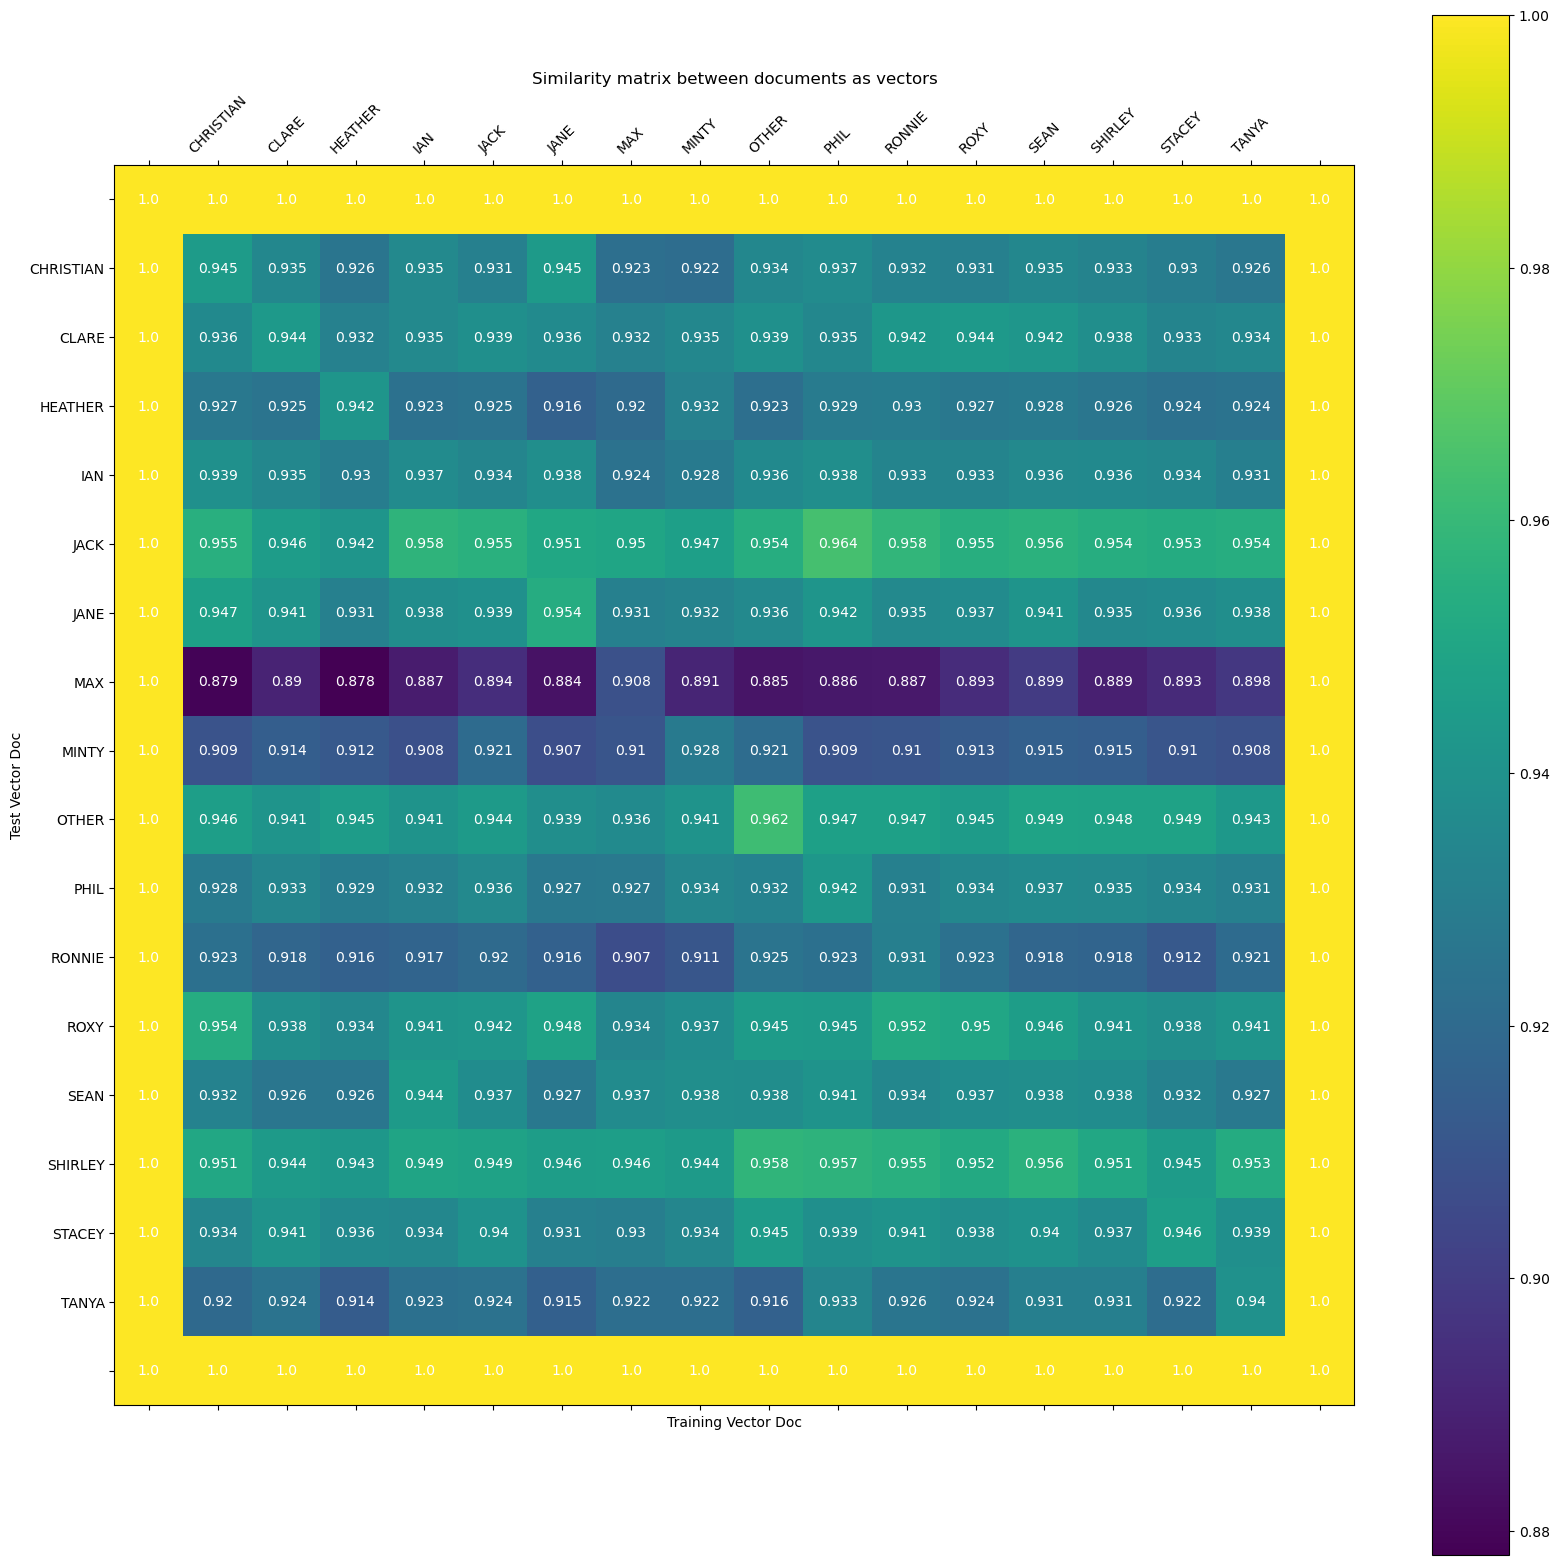

In [33]:
## take note of diagonal line
plot_heat_map_similarity(df_val_container_qn2[df_key_qn2])